In [333]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

## Задача
1. Приблизьте оба варианта моделями из класса MA.
2. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

## Загрузка временных рядов

In [334]:
PATH_SERIES = '../../src/time_line_1/Series/'

airlines_passengers = pd.read_csv(PATH_SERIES + "international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv(PATH_SERIES + "mean-monthly-air-temperature-deg.csv")

airlines_passengers_count = airlines_passengers.Count
mean_monthly_temp_deg = mean_monthly_temp.Deg


In [335]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(26, 6), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


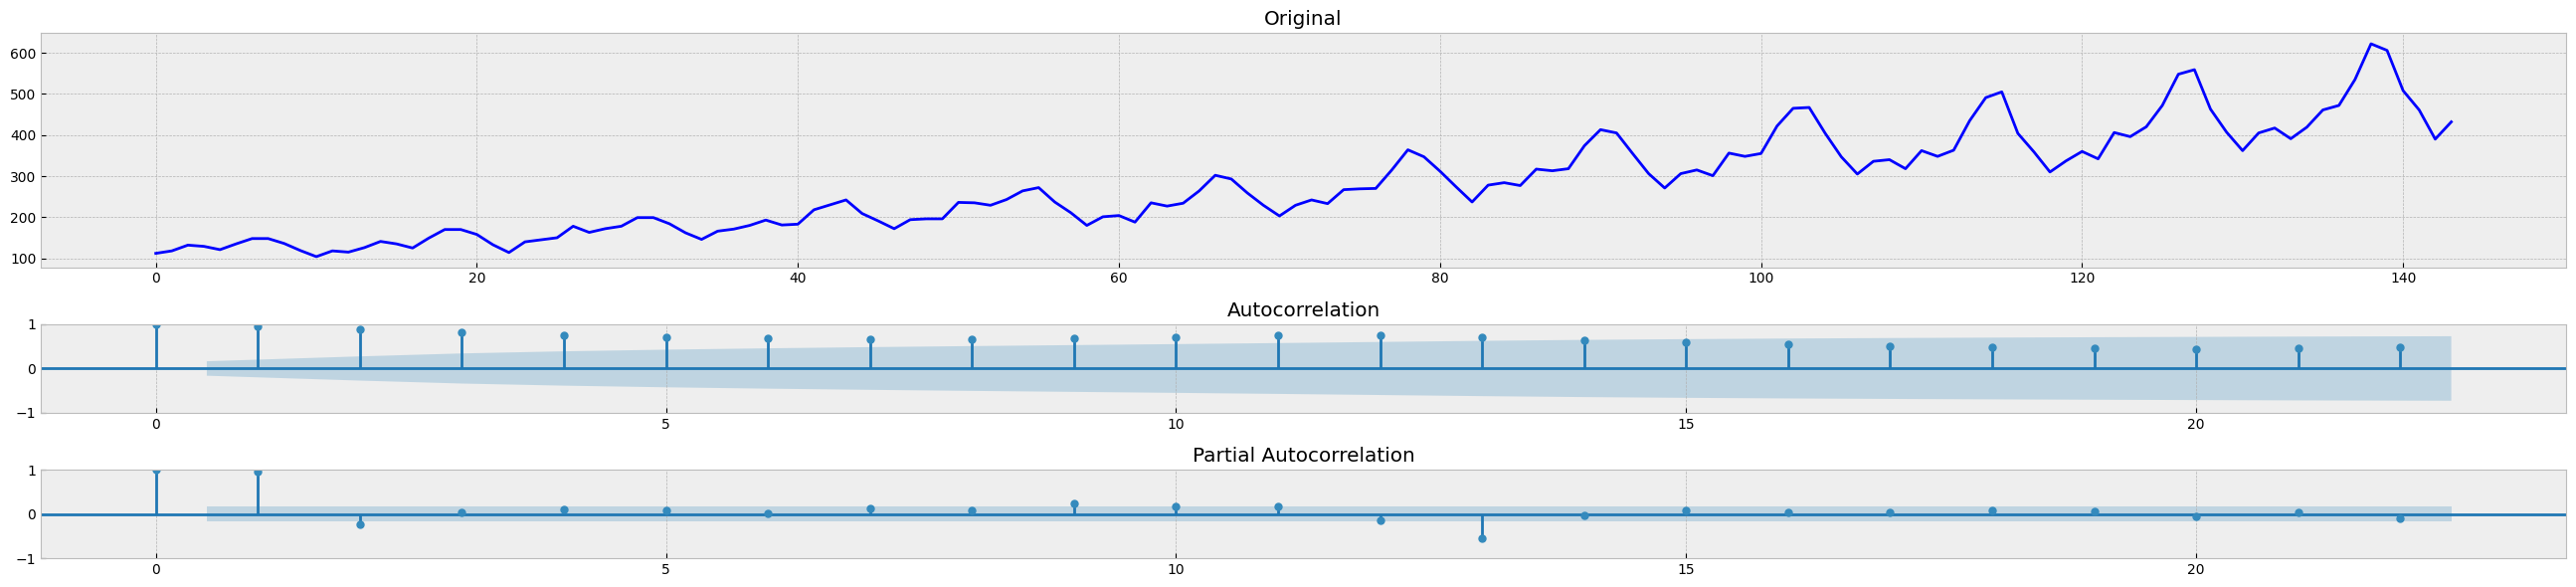

In [336]:
tsplot(airlines_passengers_count)

## Скользящее среднее

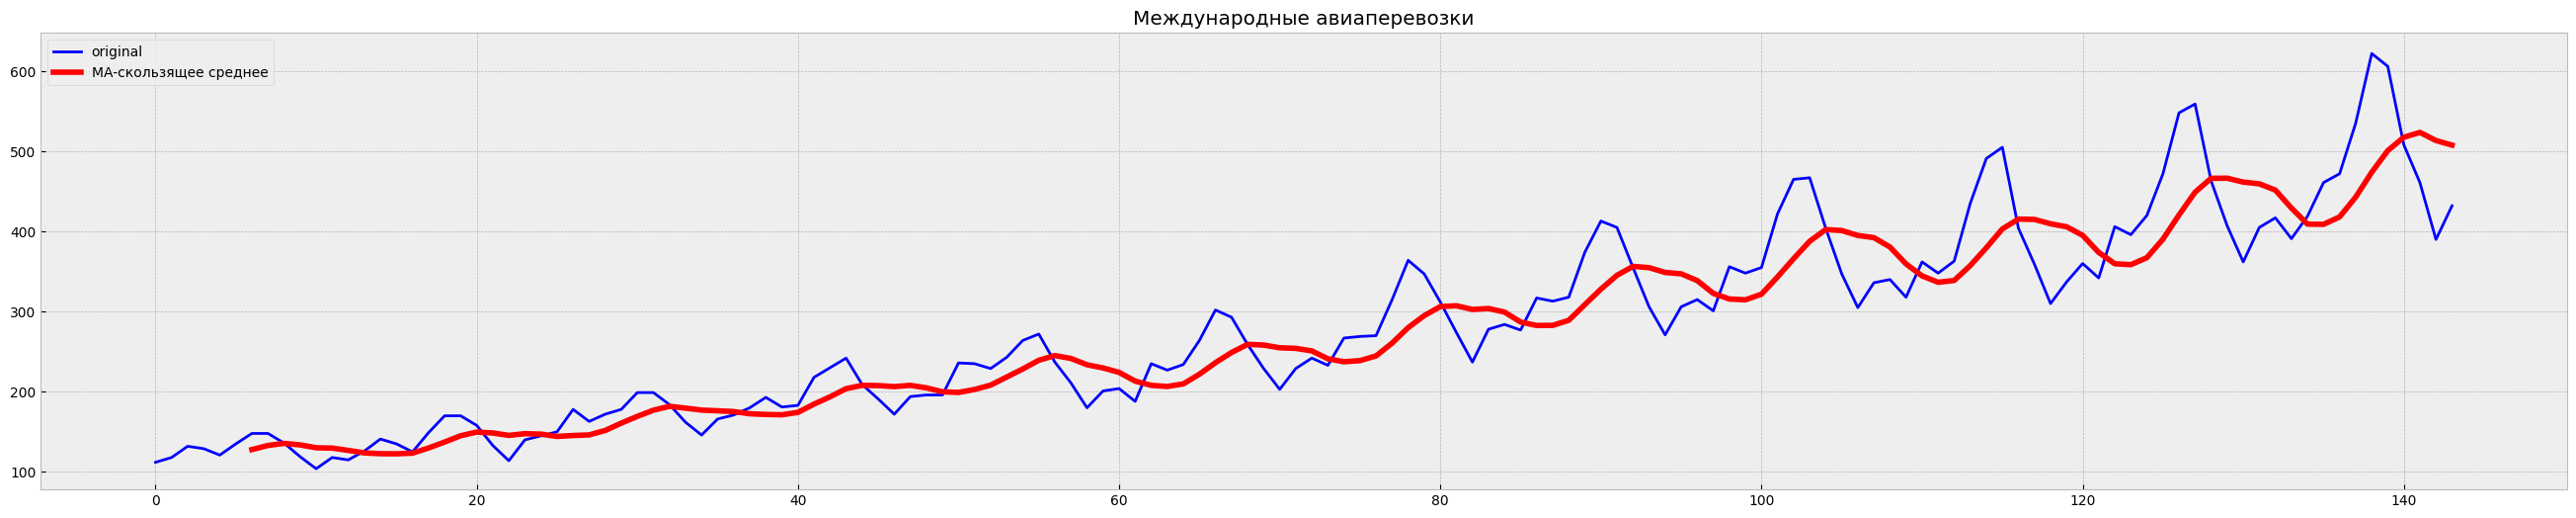

In [337]:
ma=airlines_passengers_count.rolling(7).mean()

with plt.style.context('bmh'):
    plt.figure(figsize=(33, 6))
    plt.title('Международные авиаперевозки')
    plt.plot(airlines_passengers_count, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='4', label='MA-скользящее среднее')
    plt.legend()

## Взвешенное скользящее среднее

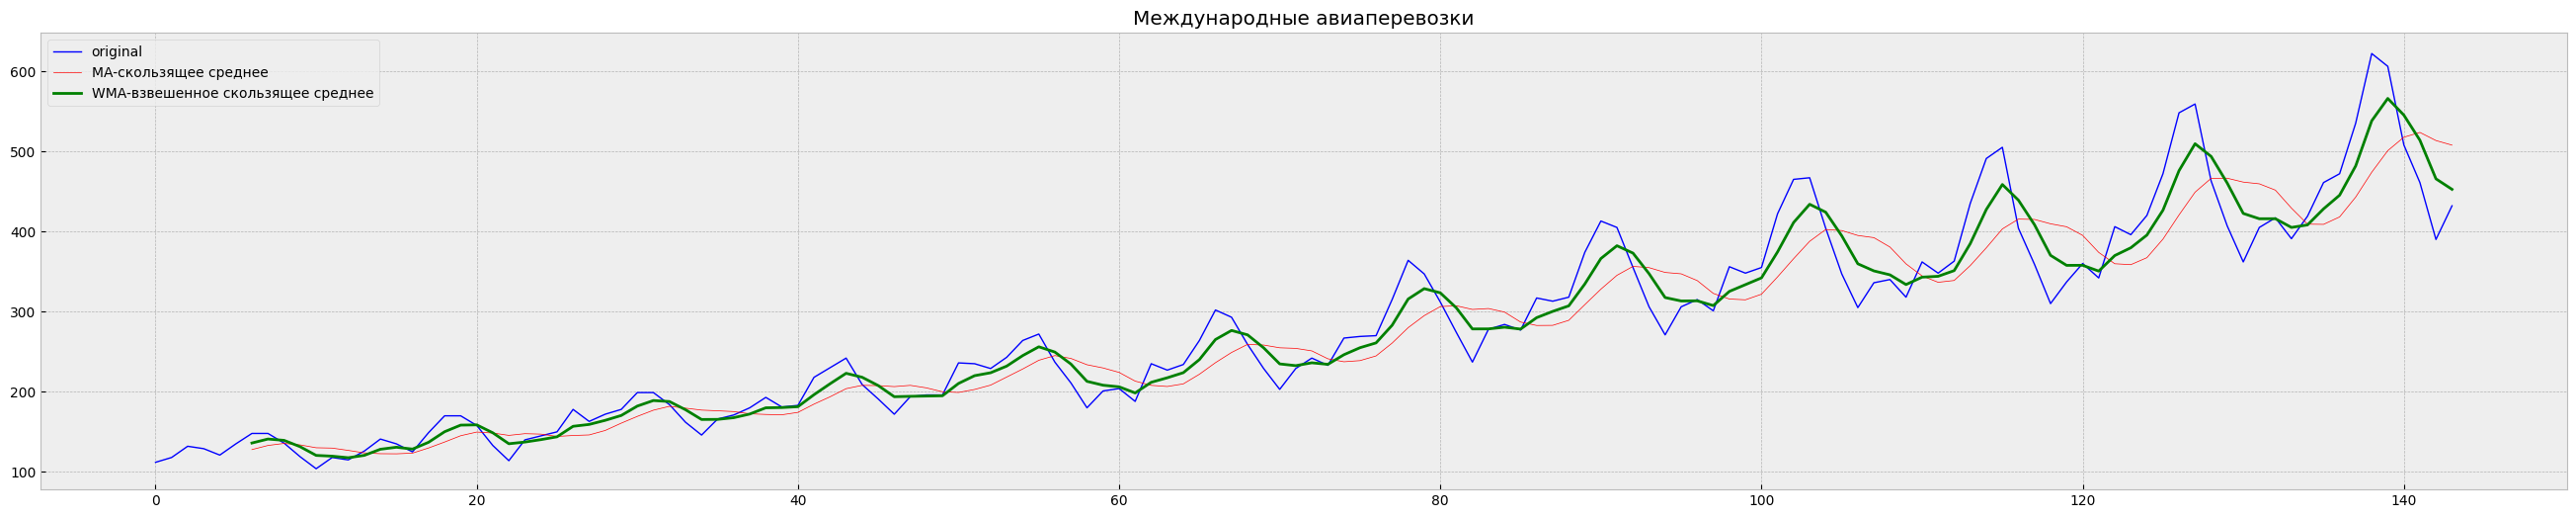

In [338]:
weights=np.array([1,1,2,3,5,8,13])
wma = airlines_passengers_count.rolling(7).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)

with plt.style.context('bmh'):
    plt.figure(figsize=(33, 6))
    plt.title('Международные авиаперевозки')
    plt.plot(airlines_passengers_count,  linewidth='1', color='blue',label='original')
    plt.plot(ma, color='red', linewidth='0.5', label='MA-скользящее среднее')
    plt.plot(wma, color='green', linewidth='2', label='WMA-взвешенное скользящее среднее')
    plt.legend()

## Экспоненциальное сглаживание

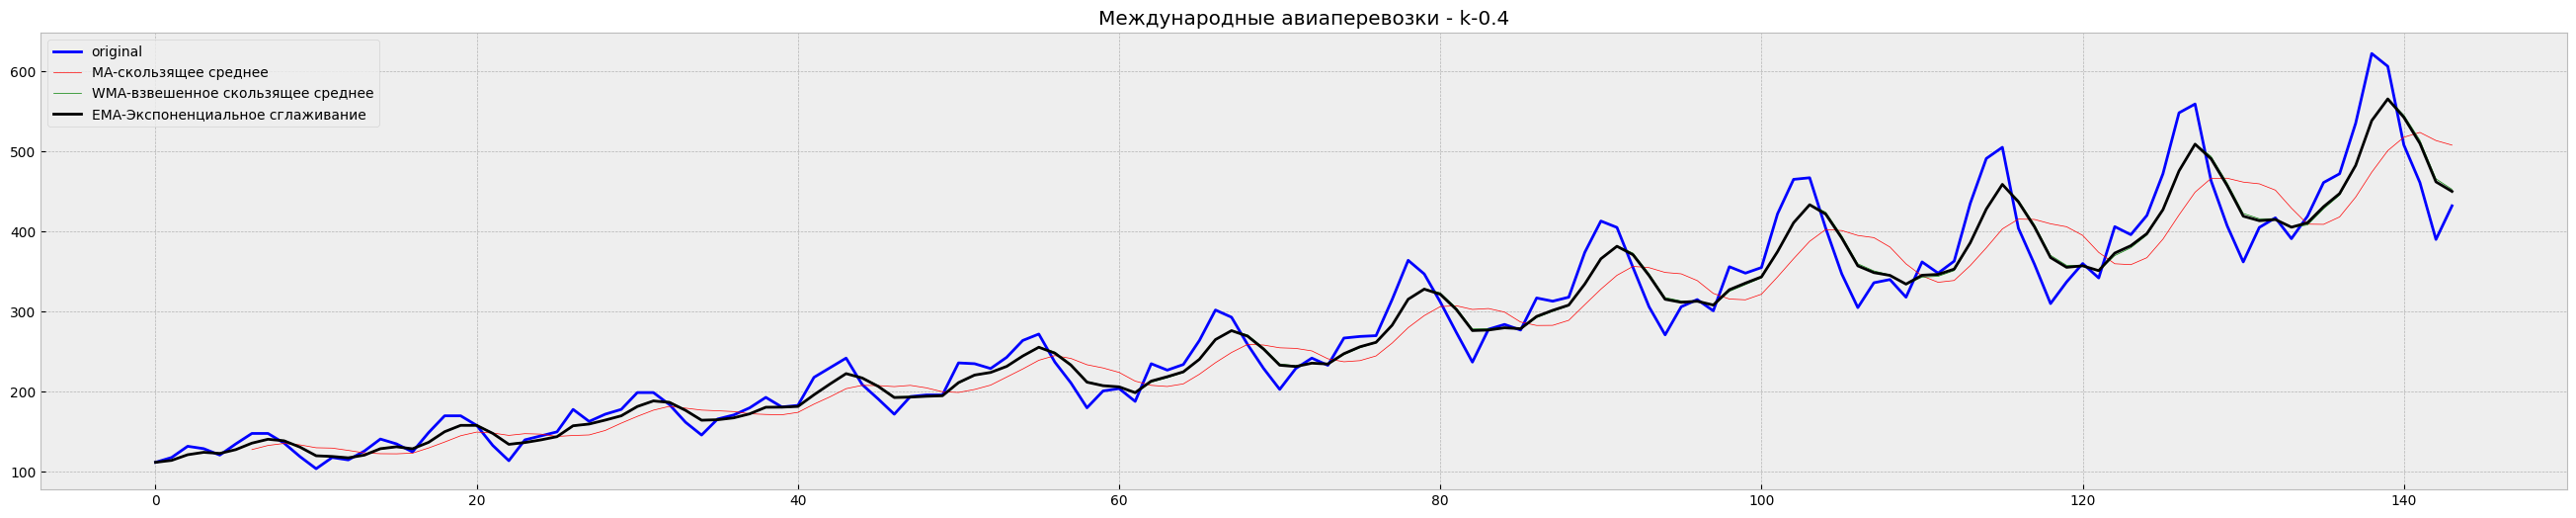

In [339]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

ema = exponential_moving_average(airlines_passengers_count, 0.4)
with plt.style.context('bmh'):
    plt.figure(figsize=(33, 6))
    plt.title('Международные авиаперевозки - k-0.4')    
    plt.plot(airlines_passengers_count, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='0.5', label='MA-скользящее среднее')
    plt.plot(wma, color='green', linewidth='0.5', label='WMA-взвешенное скользящее среднее')
    plt.plot(ema, color='black', linewidth='2', label='EMA-Экспоненциальное сглаживание')
    plt.legend()


## Двойное экспоненциальное сглаживание

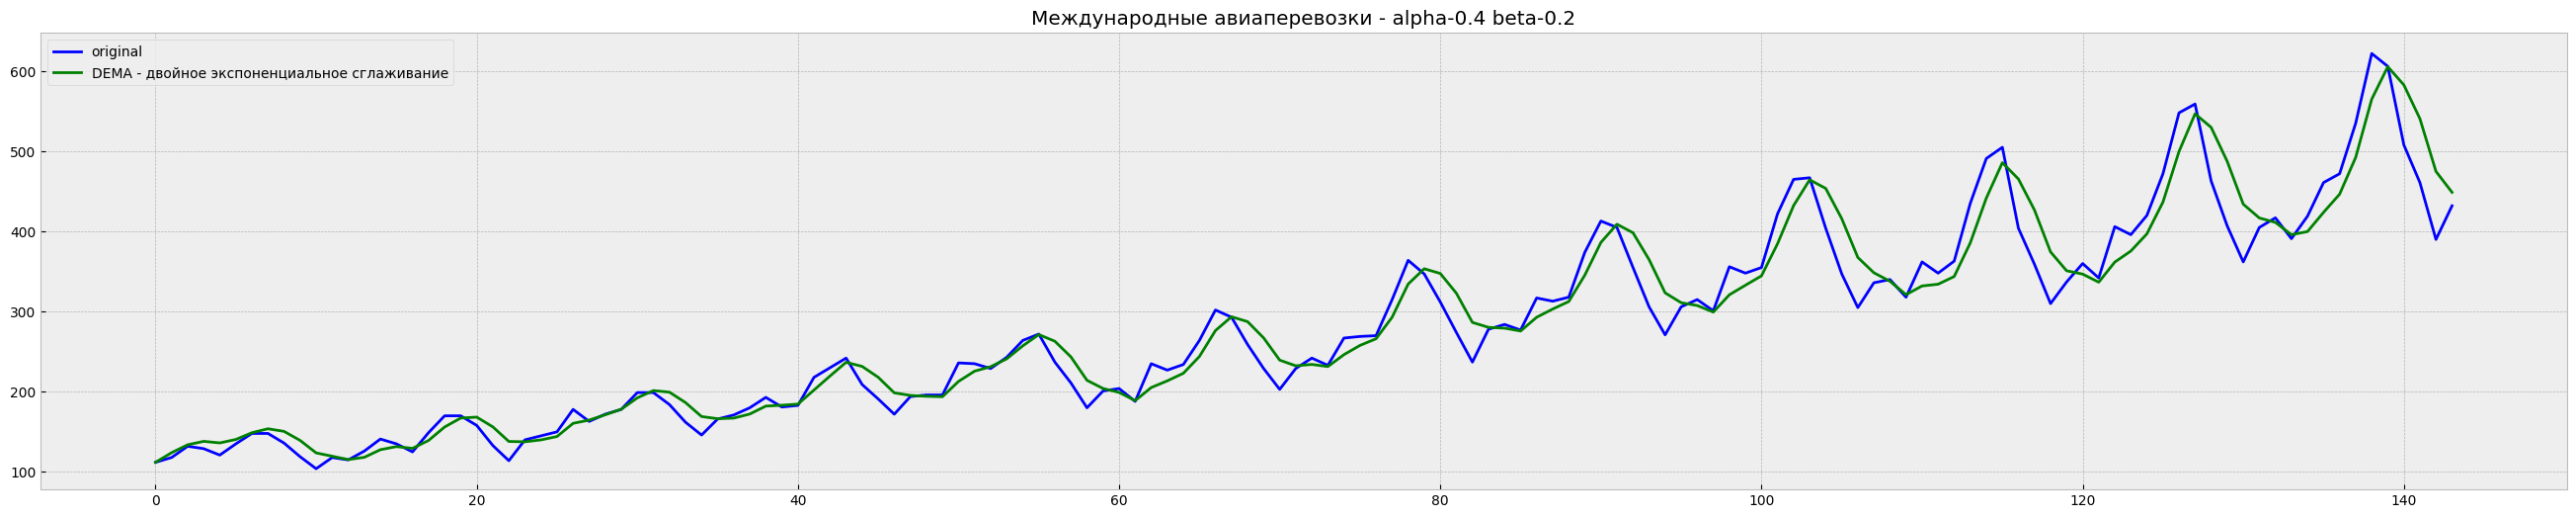

In [340]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

alpha=0.4
beta=0.2
dema = double_ema(airlines_passengers_count, alpha, beta)
with plt.style.context('bmh'):
    plt.figure(figsize=(33, 6))
    plt.title(f'Международные авиаперевозки - alpha-{alpha} beta-{beta}')    
    plt.plot(airlines_passengers_count, color='blue',label='original')
    plt.plot(dema, color='green', linewidth='2', label='DEMA - двойное экспоненциальное сглаживание')
    plt.legend()

## Хольт-Винтерс (учтем сезонность)

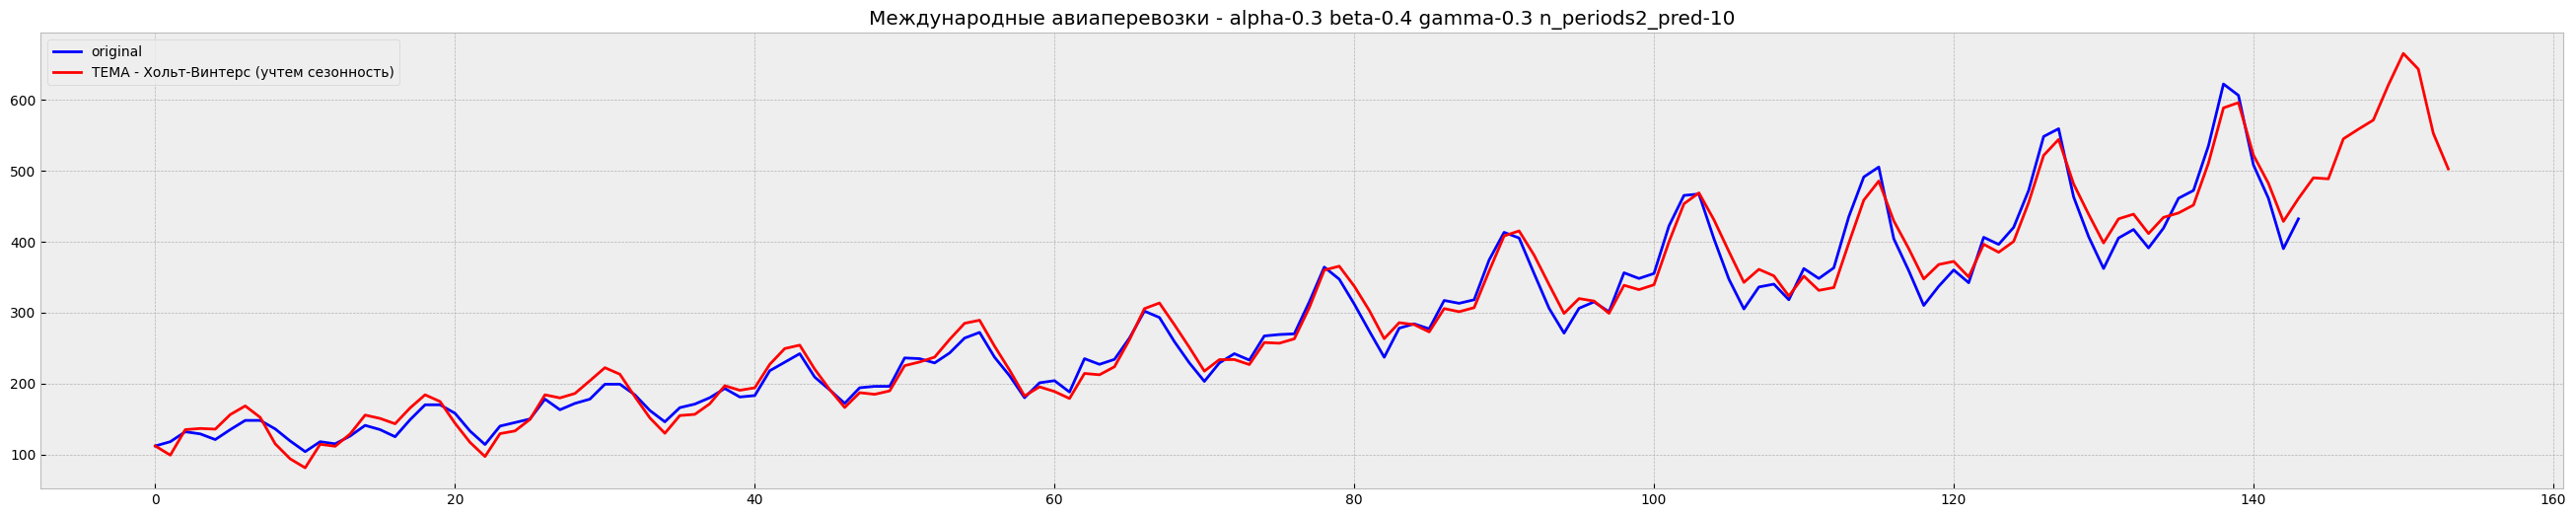

In [341]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0:
            smooth = series[0]
            trend = sum([float(series[i + slen] - series[i]) / slen]) / slen
            result.append(series[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

alpha=0.3
beta=0.4
gamma=0.3
n_periods2_pred=10

tema = triple_exponential_smoothing(airlines_passengers_count, 12, alpha, beta, gamma, n_periods2_pred)
with plt.style.context('bmh'):
    plt.figure(figsize=(33, 6))
    plt.title(f'Международные авиаперевозки - alpha-{alpha} beta-{beta} gamma-{gamma} n_periods2_pred-{n_periods2_pred}')     
    plt.plot(airlines_passengers_count, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='2', label='TEMA - Хольт-Винтерс (учтем сезонность)')
    plt.legend()

## Подбор параметров модели и тестирование результата

In [342]:
train_size=round(len(airlines_passengers_count)*.7)
test_size=round(len(airlines_passengers_count)*.25)

In [343]:
train, test, val = airlines_passengers_count[:train_size], airlines_passengers_count[train_size:train_size+test_size], \
    airlines_passengers_count[train_size+test_size:]

def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1365.3324154366674
        x: [ 1.000e+00  1.822e-02  1.000e+00]
      nit: 6
      jac: [-3.926e+02  9.095e-05 -0.000e+00]
     nfev: 60
     njev: 15
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


Тест

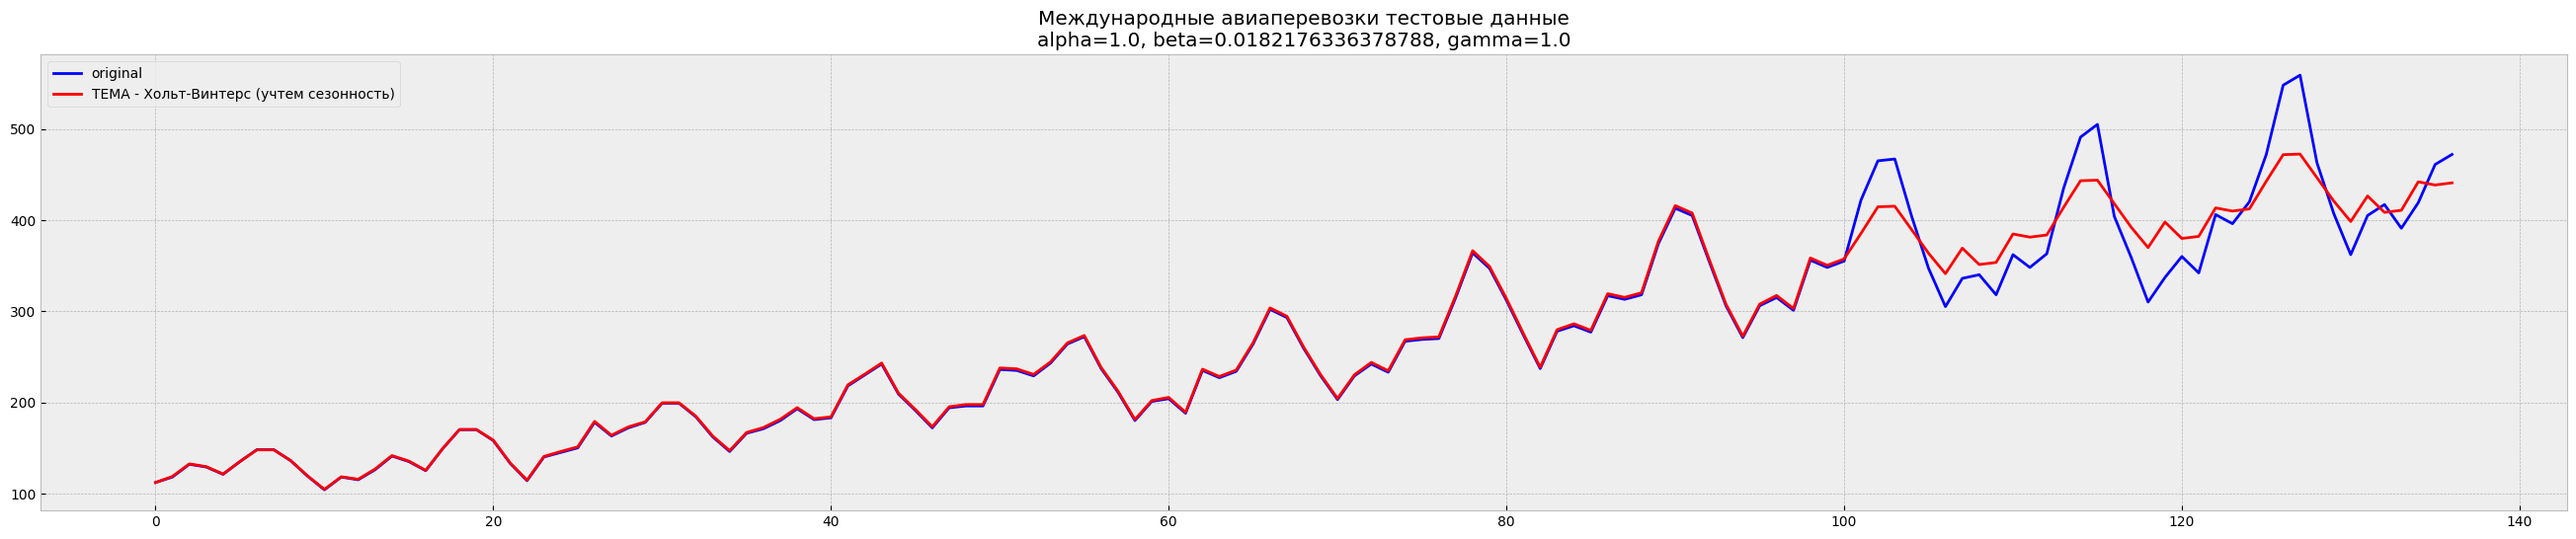

In [344]:
tema = triple_exponential_smoothing(train, 12, alpha_opt, beta_opt, gamma_opt, len(test))
with plt.style.context('bmh'):
    plt.figure(figsize=(33, 6))   
    plt.plot(airlines_passengers_count[:train_size+test_size], color='blue',label='original')
    plt.plot(tema, color='red', linewidth='2', label='TEMA - Хольт-Винтерс (учтем сезонность)')
    plt.title("Международные авиаперевозки тестовые данные\nalpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

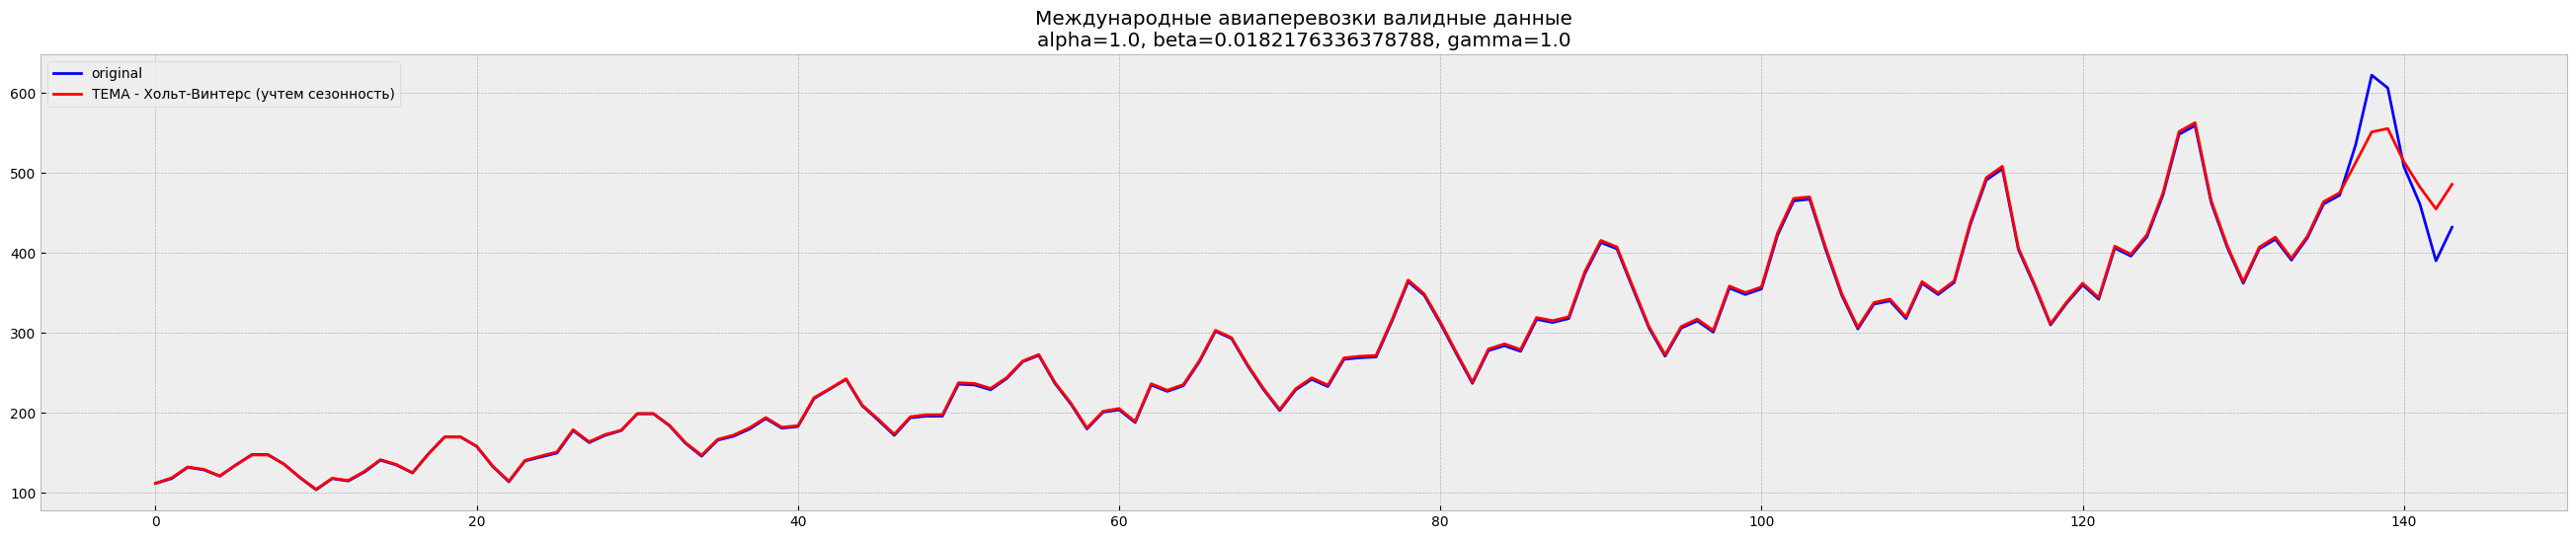

In [345]:
tema = triple_exponential_smoothing(airlines_passengers_count[:train_size+test_size], 12, alpha_opt, beta_opt, gamma_opt, len(val))
with plt.style.context('bmh'):
    plt.figure(figsize=(33, 6))     
    plt.plot(airlines_passengers_count, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='2', label='TEMA - Хольт-Винтерс (учтем сезонность)')
    plt.title("Международные авиаперевозки валидные данные\nalpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

подбор коэффициентов и проверка качества модели

In [346]:

train, val = airlines_passengers_count[:train_size], airlines_passengers_count[train_size:]

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []

    for train_split, test_split in split.split(mean_monthly_temp):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)
    return np.mean(np.array(errors))

opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 9.539210950455393e-09
        x: [ 5.555e-02  1.906e-01  9.115e-01]
      nit: 68
      jac: [-1.758e-06 -7.367e-06  4.125e-06]
     nfev: 340
     njev: 85
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


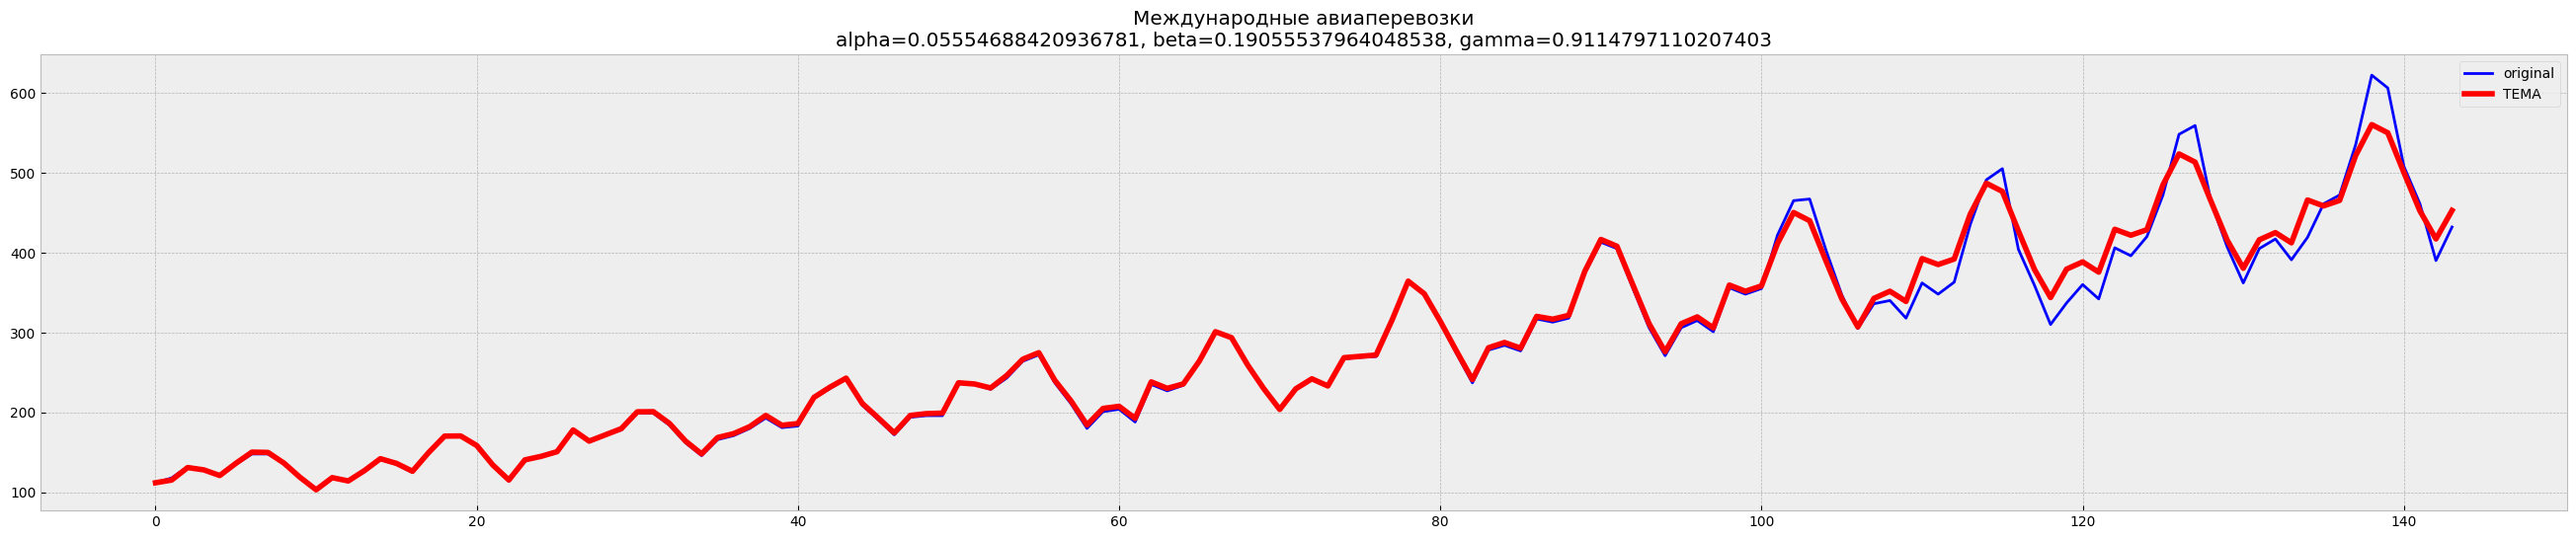

In [347]:
tema = triple_exponential_smoothing(airlines_passengers_count[:train_size], 12, alpha_opt, beta_opt, gamma_opt, len(val))
with plt.style.context('bmh'):
    plt.figure(figsize=(33, 6))      
    plt.plot(airlines_passengers_count, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("Международные авиаперевозки\nalpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

In [348]:
r2_score(y_pred=tema, y_true=airlines_passengers_count)

0.9862469228729048

## Работа с стационарным временным рядом `mean_monthly_temp`

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


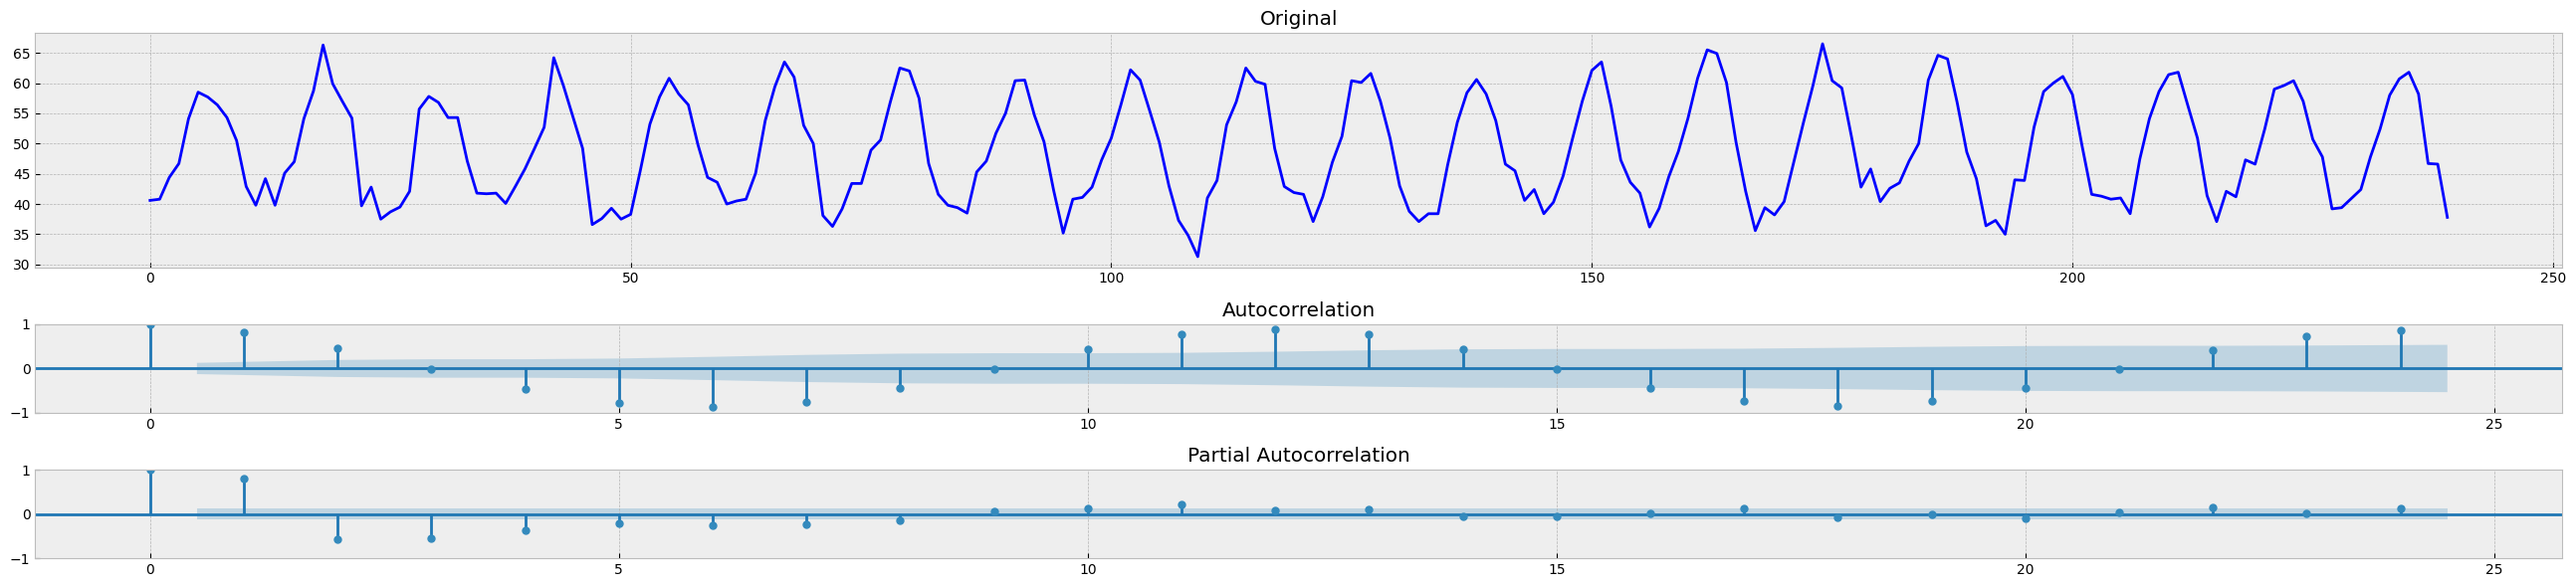

In [349]:
tsplot(mean_monthly_temp_deg)

## Скользящее среднее

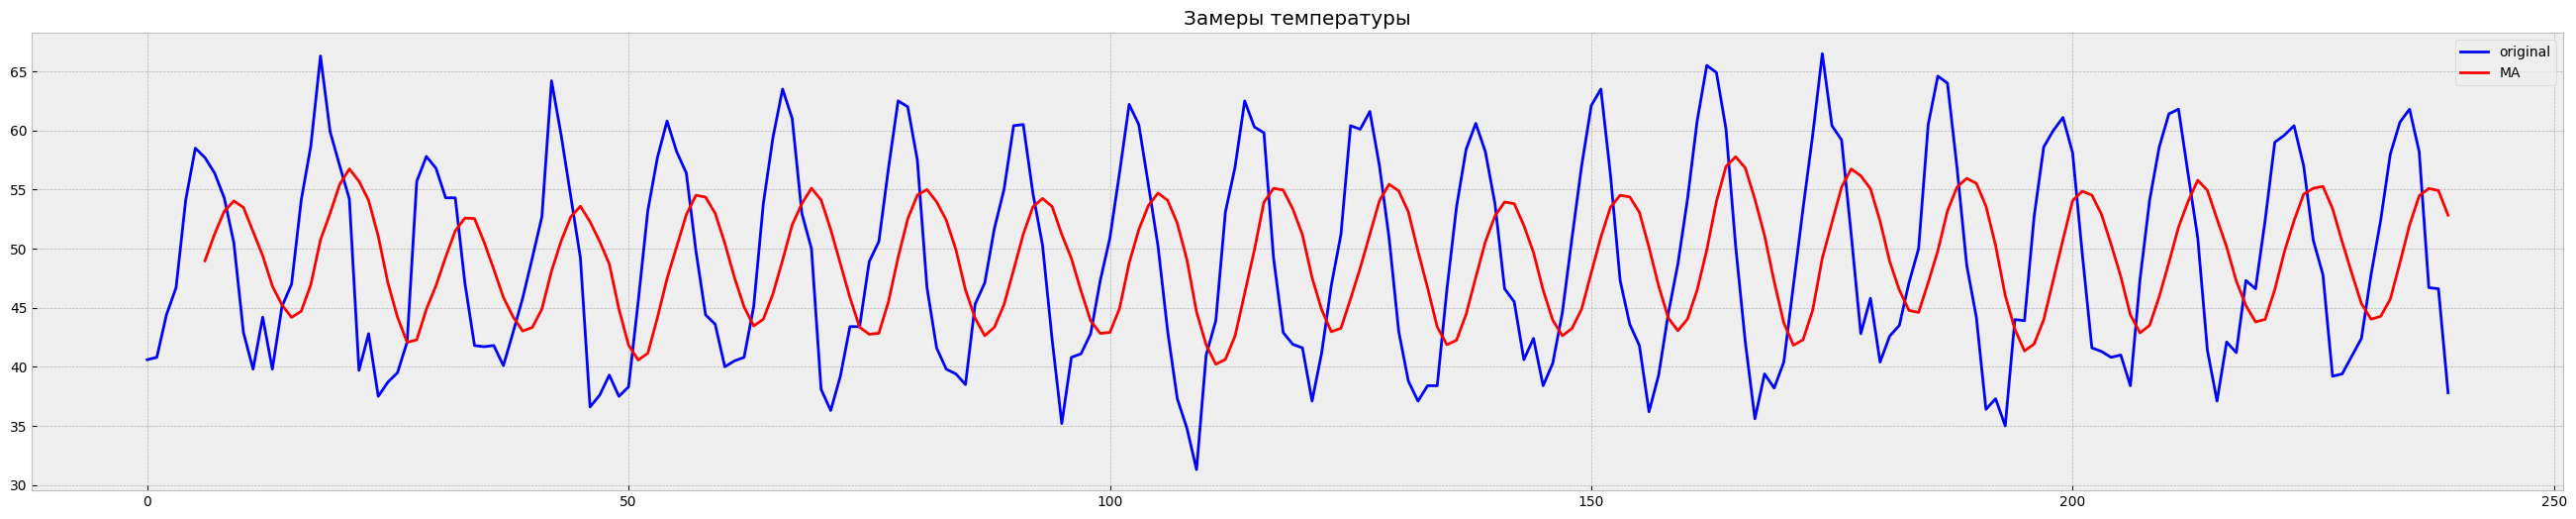

In [350]:
ma=mean_monthly_temp_deg.rolling(7).mean()

with plt.style.context('bmh'):
    plt.figure(figsize=(33, 6))   
    plt.title('Замеры температуры')
    plt.plot(mean_monthly_temp_deg, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.legend()

## взвешенное скользящее среднее

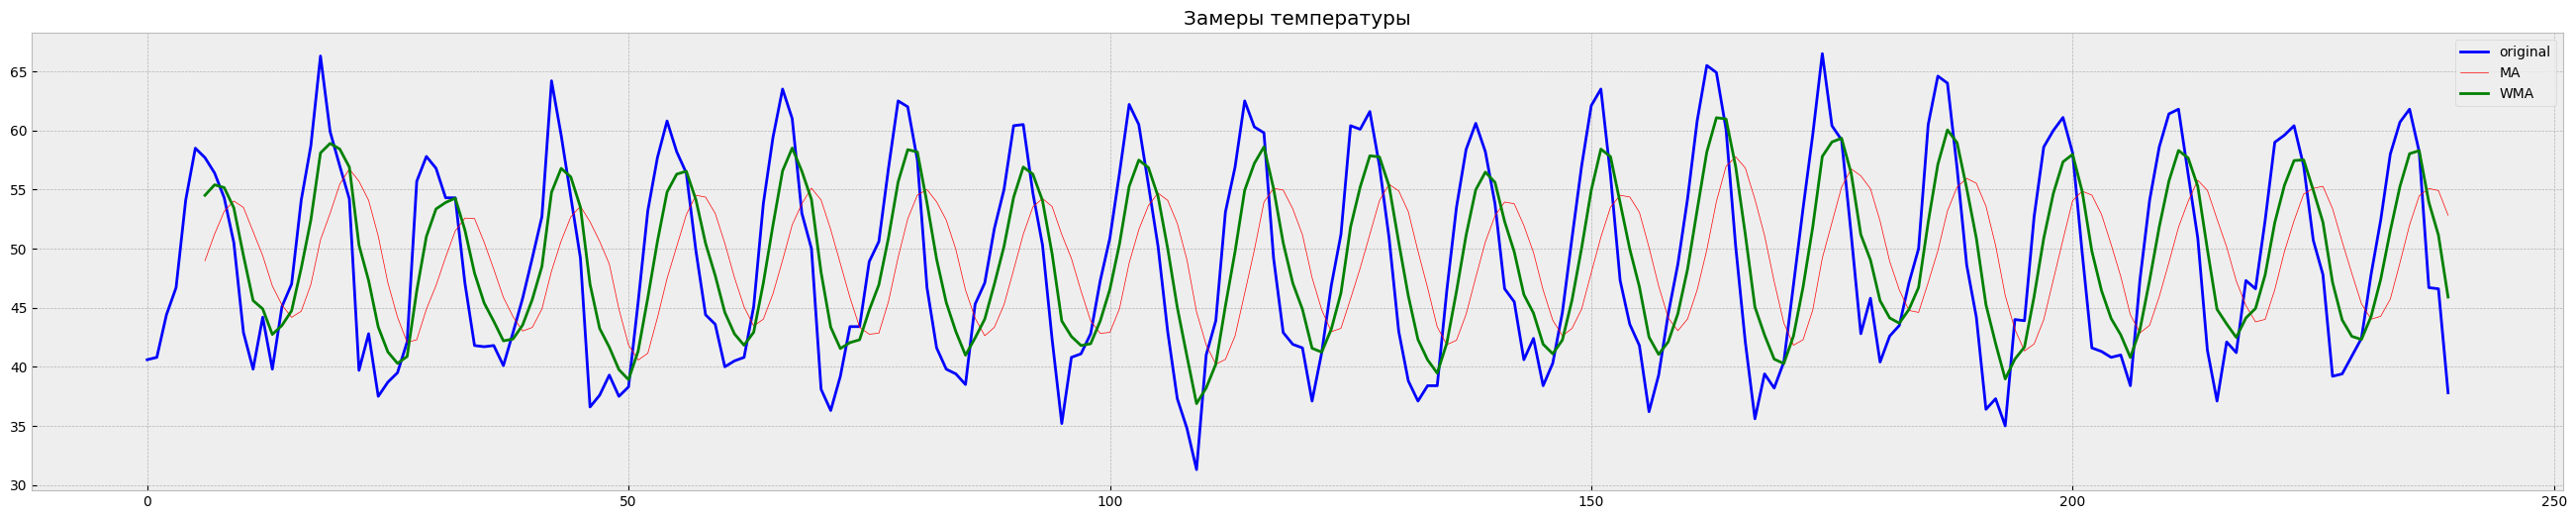

In [351]:
weights=np.array([1,1,2,3,5,8,13])
wma = mean_monthly_temp_deg.rolling(7).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)

with plt.style.context('bmh'):
    plt.figure(figsize=(33, 6))
    plt.title('Замеры температуры')
    plt.plot(mean_monthly_temp_deg, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='0.5', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

## экспоненциальное сглаживание

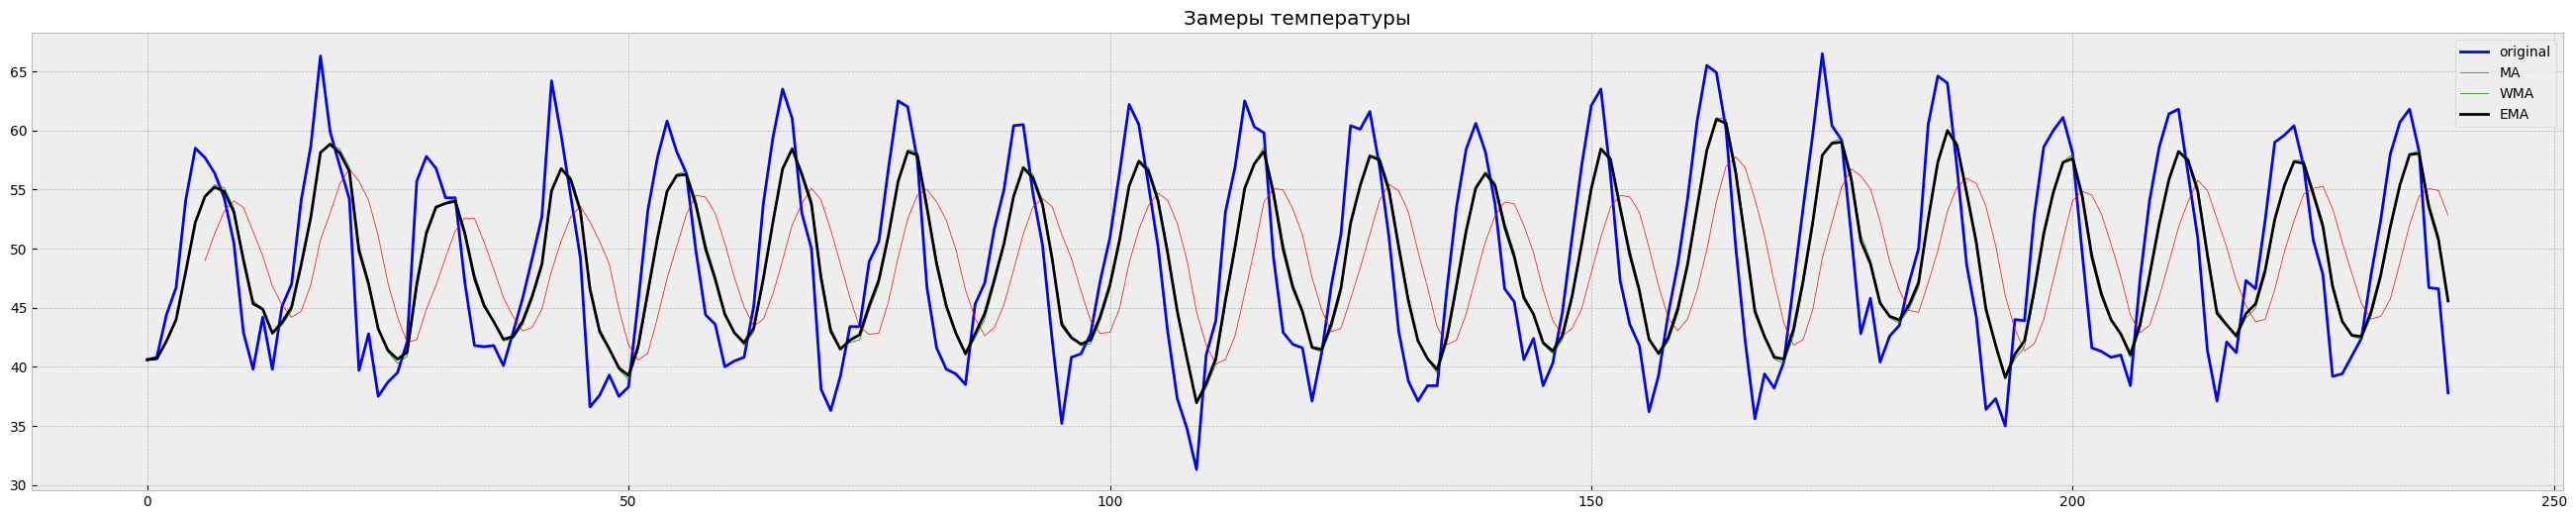

In [352]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

ema = exponential_moving_average(mean_monthly_temp_deg, 0.4)
with plt.style.context('bmh'):
    plt.figure(figsize=(33, 6))
    plt.title('Замеры температуры')   
    plt.plot(mean_monthly_temp_deg, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='0.5', label='MA')
    plt.plot(wma, color='green', linewidth='0.5', label='WMA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

## двойное экспоненциальное сглаживание

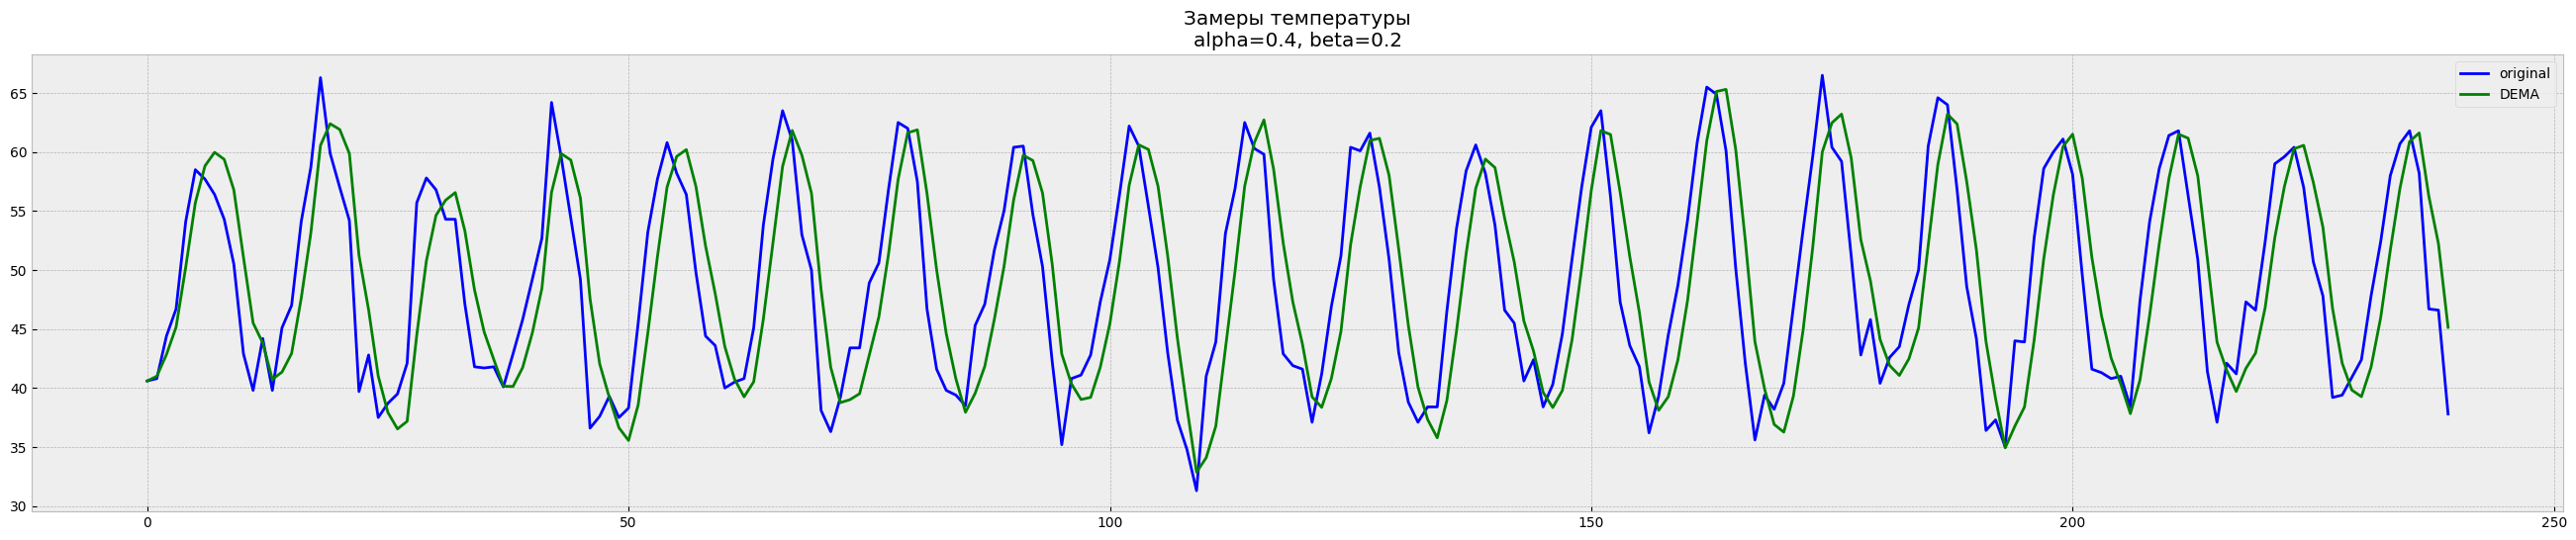

In [353]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

alpha=0.4
beta=0.2
dema = double_ema(mean_monthly_temp_deg, alpha, beta)
with plt.style.context('bmh'):
    plt.figure(figsize=(33, 6))
    plt.plot(mean_monthly_temp_deg, color='blue',label='original')
    plt.plot(dema, color='green', linewidth='2', label='DEMA')
    plt.title("Замеры температуры\nalpha={}, beta={}".format(alpha, beta))
    plt.legend()

## Хольт-Винтерс (учтем сезонность)

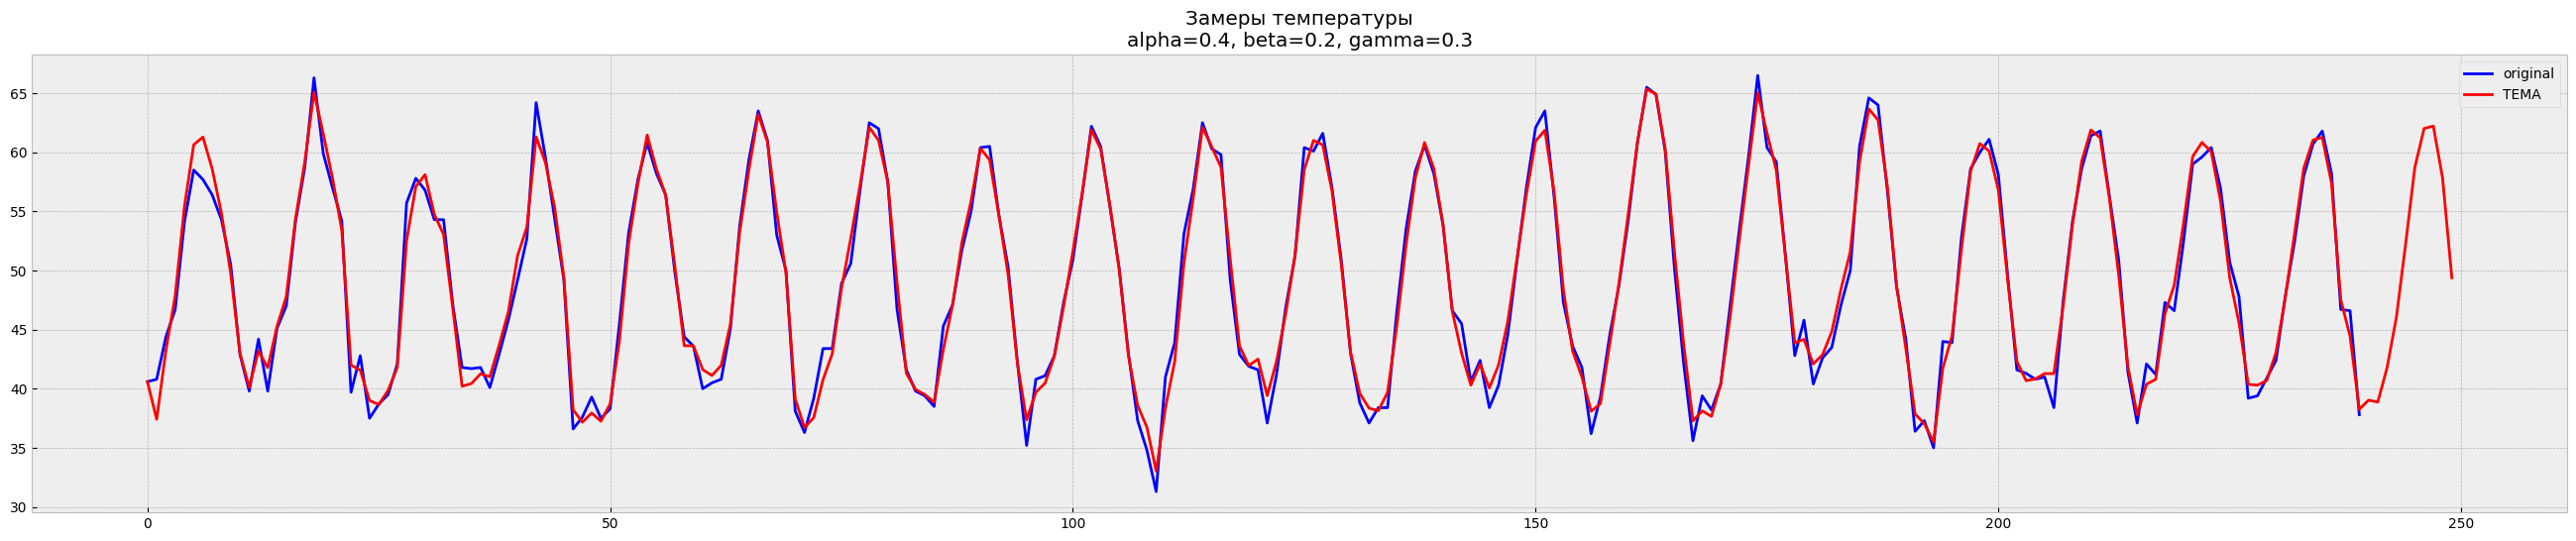

In [354]:
alpha=0.4
beta=0.2
gamma=0.3
n_periods2_pred=10

tema = triple_exponential_smoothing(mean_monthly_temp_deg[:], 12, alpha, beta, gamma, n_periods2_pred)
with plt.style.context('bmh'):
    plt.figure(figsize=(33, 6))   
    plt.plot(mean_monthly_temp_deg, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='2', label='TEMA')
    plt.title("Замеры температуры\nalpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.legend()

подбор параметров модели и тестирование

In [355]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid

train_size = int(len(mean_monthly_temp_deg) * 0.9)
train, val = mean_monthly_temp_deg[:train_size], mean_monthly_temp_deg[train_size:]

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=5) 
    errors = []
    mae_errors = []
    r2_scores = []
    
    for train_index, test_index in split.split(mean_monthly_temp_deg):
        train_split, test_split = mean_monthly_temp_deg[train_index], mean_monthly_temp_deg[test_index]
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        
        mse_error = mean_squared_error(test_split, predictions)
        mae_error = mean_absolute_error(test_split, predictions)
        r2 = r2_score(test_split, predictions)
        
        errors.append(mse_error)
        mae_errors.append(mae_error)
        r2_scores.append(r2)
        
    # print(f"Средняя MSE: {np.mean(errors)}, Средняя MAE: {np.mean(mae_errors)}, Средняя R2: {np.mean(r2_scores)}")
    return np.mean(errors)

# Перебор параметров
param_grid = {
    'alpha': np.linspace(0.0, 1.0, 11),
    'beta': np.linspace(0.0, 1.0, 11),
    'gamma': np.linspace(0.0, 1.0, 11)
}

grid = ParameterGrid(param_grid)
best_params = None
lowest_mse = float('inf')

for params in grid:
    mse = mse_cross_val([params['alpha'], params['beta'], params['gamma']])
    if mse < lowest_mse:
        lowest_mse = mse
        best_params = params

alpha_opt, beta_opt, gamma_opt = best_params['alpha'], best_params['beta'], best_params['gamma']
print(f"Оптимальные параметры после перебора: alpha={alpha_opt}, beta={beta_opt}, gamma={gamma_opt}")


Оптимальные параметры после перебора: alpha=0.1, beta=0.0, gamma=0.2


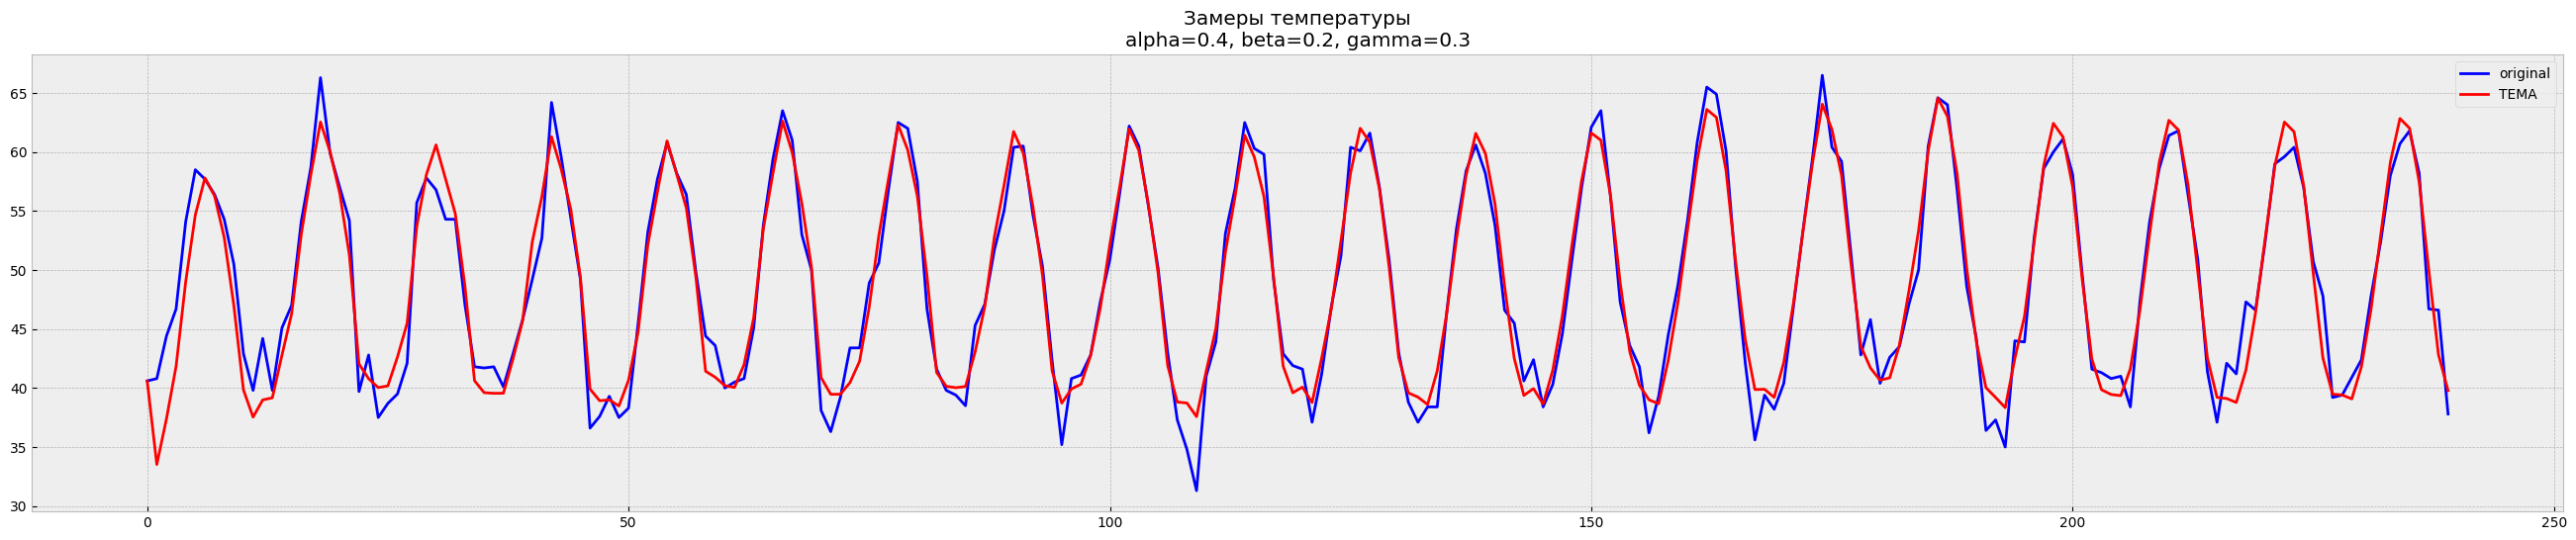

In [356]:
tema = triple_exponential_smoothing(mean_monthly_temp_deg[:train_size], 12, alpha_opt, beta_opt, gamma_opt, len(val))
with plt.style.context('bmh'):
    plt.figure(figsize=(33, 6)) 
    plt.plot(mean_monthly_temp_deg, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='2', label='TEMA')
    plt.title("Замеры температуры\nalpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.legend()

In [357]:
r2_score(y_pred=tema, y_true=mean_monthly_temp_deg)

0.9444888676158959

## Вывод

+ были загружены данные
+ проверка на стационарность
+ использовались различные модели для стационарно и не стационарного временного ряда в итоге основной упор был сделан на модели `Хольта-Винтерса` `тройное экспоненциальное сглаживание`
  + Уровень (`alpha`) — основной уровень временного ряда.
  + Тренд (`beta`) — изменение уровня временного ряда с течением времени.
  + Сезонность (`gamma`) — повторяющиеся сезонные колебания в данных.

+ в итоге для модели `Международные авиаперевозки` которая имеет тренд, сезоность результат получился практически `100%` `r2_score` = `0.9862469228729048`
+ для временного ряда с замерами температуры `r2_score` `0.9444888676158959` но пришлось дольше подбирать параметры модели и использовать `ParameterGrid`, а так же увеличить параметры кросс валидации
